# Questions

# Objectives
YWBAT
- define what the anova test is testing for
- complete an anova test in python
- calculate power in python
- how power analysis is related to ttests

In [19]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_iris
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.stats as stats

import matplotlib.pyplot as plt

In [5]:
iris = load_iris()
data = iris.data
target = iris.target
features = iris.feature_names
target_names = iris.target_names

In [7]:
df = pd.DataFrame(data, columns=features)
df['target'] = target
df['target_names'] = df['target'].apply(lambda x: target_names[x])
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


# When would I use an Anova test?
- when we need to check different variance of the data. 
- when we want to compare multiple variances to one variable
- Anova is used for multiple groups (2 or more groups)

# What does ANOVA test for?
### H0: mu1 = mu2 = ... = mu_n, for all groups

### HA: mu_i $\neq$ mu_j,  for i!=j

# So how do we set this up in Python? 

# Let's test the mean of sepal length of all three groups using ANOVA (F_oneway)

In [14]:
sl_setosa = df.loc[df['target_names']=='setosa', ['sepal length (cm)']].values
sl_versicolor = df.loc[df['target_names']=='versicolor', ['sepal length (cm)']].values
sl_virginica = df.loc[df['target_names']=='virginica', ['sepal length (cm)']].values

Text(0.5,1,'Sepal Length Distribution by Type')

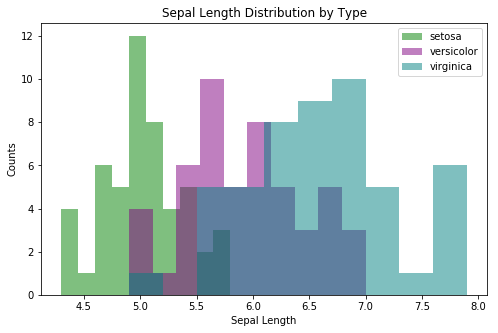

In [16]:
# We should always visualize our data
plt.figure(figsize=(8, 5))
plt.hist(sl_setosa, color='g', alpha=0.5, label='setosa')
plt.hist(sl_versicolor, color='purple', alpha=0.5, label='versicolor')
plt.hist(sl_virginica, color='teal', alpha=0.5, label='virginica')
plt.legend()
plt.xlabel("Sepal Length")
plt.ylabel("Counts")
plt.title("Sepal Length Distribution by Type")

In [18]:
# H0: mu1 = mu2 = mu3
# HA: mui != muj

scs.f_oneway(sl_setosa, sl_versicolor, sl_virginica)

# p = 0.0 -> reject H0

F_onewayResult(statistic=array([119.26450218]), pvalue=array([1.66966919e-31]))

# Unfortunately, Anova doesn't tell us which group is different, how can we see the different group?

- So let's run a **tukey test** to see group by group comparisons

In [26]:
mc = stats.multicomp.MultiComparison(df['sepal length (cm)'], df['target_names'])

In [27]:
results = mc.tukeyhsd()

In [28]:
print(results)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1     group2   meandiff p-adj lower  upper  reject
---------------------------------------------------------
    setosa versicolor     0.93 0.001 0.6862 1.1738   True
    setosa  virginica    1.582 0.001 1.3382 1.8258   True
versicolor  virginica    0.652 0.001 0.4082 0.8958   True
---------------------------------------------------------


# Okay, so our groups are different..that's great, but how different? 

# What is power?
* power = 1 - $\beta$, where $\beta$ is the probablity we make a type II error
* if we have a high chance of making a type II error, beta is really big
    * if beta = 0.8 -> power = 0.2
* power low -> bad
* power high -> good

* cohen's d is directly proportional to power

let's do some power analysis

In [31]:
# the first step to calculating power is first

# choose our 2 groups
sl_setosa = sl_setosa.flatten()
sl_versicolor = sl_versicolor.flatten()

In [34]:
# we need to calculate cohens d 
# find it on stack overflow
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [37]:
effect_size = cohen_d(sl_versicolor, sl_setosa)
effect_size

2.104197253509822

In [32]:
pa = stats.power.TTestIndPower()

In [38]:
pa.solve_power(effect_size=effect_size, nobs1=50, alpha=0.5)

1.0

Text(0.5,1,'Sepal Length Distribution by Type')

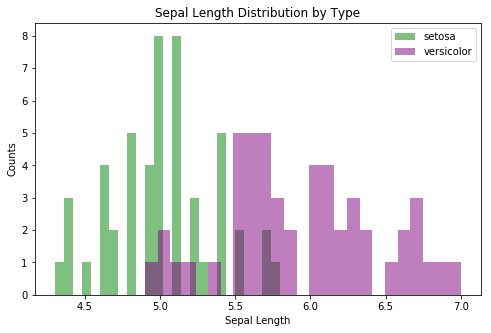

In [40]:
plt.figure(figsize=(8, 5))
plt.hist(sl_setosa, color='g', alpha=0.5, label='setosa', bins=25)
plt.hist(sl_versicolor, color='purple', alpha=0.5, label='versicolor', bins=25)
plt.legend()
plt.xlabel("Sepal Length")
plt.ylabel("Counts")
plt.title("Sepal Length Distribution by Type")

# How to conduct power analysis
- import all necessary libraries
- choose your two groups
- calcualte cohens d between your two groups
- pass in your effect size, nobs1 and alpha into ttestindpower
- done

# let's go through an example from start to finish

Q1: is petal width a good predictor for iris type (versicolor, virginica)? 

In [42]:
pw_versicolor = df.loc[df['target_names']=='versicolor', ['petal width (cm)']].values.flatten()
pw_virginica = df.loc[df['target_names']=='virginica', ['petal width (cm)']].values.flatten()

In [43]:
# first test if the means are different?
# i can conduct an indepdent ttest

In [52]:
# first check assumptions
# check for normal distributions -> shapiro

scs.shapiro(pw_versicolor), scs.shapiro(pw_virginica)

# since one of them isn't normal we must resample the means

pw_vers_sample_means = []
pw_virg_sample_means = []

for i in range(30):
    samp1 = np.random.choice(pw_versicolor, 50)
    samp2 = np.random.choice(pw_virginica, 50)
    pw_vers_sample_means.append(samp1.mean())
    pw_virg_sample_means.append(samp2.mean())

In [53]:
scs.shapiro(pw_vers_sample_means), scs.shapiro(pw_virg_sample_means)

((0.9768537282943726, 0.7371708154678345),
 (0.9765429496765137, 0.7280974984169006))

In [56]:
# yay! they're normal! 

# H0: mu1 = mu2
# HA: mu1 != mu2

scs.ttest_ind(pw_vers_sample_means, pw_virg_sample_means, equal_var=False)

Ttest_indResult(statistic=-76.86452270014743, pvalue=1.0450788020596916e-58)

(array([1., 0., 1., 3., 7., 5., 4., 6., 2., 1.]),
 array([1.916 , 1.9344, 1.9528, 1.9712, 1.9896, 2.008 , 2.0264, 2.0448,
        2.0632, 2.0816, 2.1   ]),
 <a list of 10 Patch objects>)

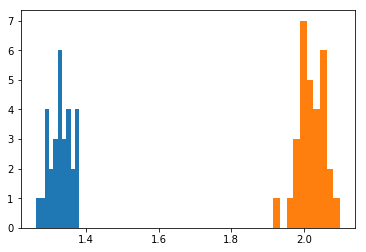

In [57]:
plt.hist(pw_vers_sample_means)
plt.hist(pw_virg_sample_means)

In [59]:
# Now conduct power analysis
effect_size = cohen_d(pw_virg_sample_means, pw_vers_sample_means)
effect_size

19.84633442212353

In [62]:
power = pa.solve_power(effect_size=effect_size, nobs1=30, alpha=0.5)
power

1.0

# In conclusion we can with almost 100% certainty differentiate veriscolor and virginicas by their petal width.

# what did you learn today?
* learned that anova is for more than 2 comparisons
* how to calculate cohen's d and how to interpret 2 different distributions
* Steps to work through when evaluating data against the null hypothesis
* cohens's d and it's relationship to power